# analysis of DNA-MERFISH for CTP11

by Pu Zheng

2021.11.10

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_5\20211108-P_brain_CTP11-1000_DNA_only



# 0. Load basic functions

In [139]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

12320


In [ ]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(get_img_info)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

# 1. Pre-processing

In [2]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_5\20211108-P_brain_CTP11-1000_DNA_only',
             'save_folder':r'\\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only',
             'experiment_type': 'DNA',
             'num_threads': 26,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor',
             'shared_parameters':{
                     'single_im_size':[60,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':500,
                     'max_num_seeds': None,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':True
                 }, 
             }


In [ ]:
_fov_id = 5
_overwrite = False

#for _fov_id in np.arange(5, 45):

# create fov class
fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          _save_info_to_file=False, # set this to be false when hdf5 already exists
                                          )

# 2. Process image into candidate spots
fov.parallel=True
fov.combo_ref_id = 0

fov._process_image_to_spots('combo', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=False, 
                            _fit_spots=True,
                            _overwrite_drift=_overwrite, _overwrite_image=_overwrite,
                            _overwrite_spot=_overwrite,
                            _verbose=True)
# 3. Load DAPI image
fov._load_dapi_image()


## check drifts

In [ ]:
sel_bits = [9,45,66]
bead_ims = fov._load_bead_ims_for_bits(sel_bits, 'combo')

In [ ]:
visual_tools.imshow_mark_3d_v2(bead_ims)

# 2. Partiton spots into cells

In [8]:
save_folder = fov_param['save_folder']
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
print(len(save_filenames))

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

42
Use segmentation_folder: H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Segmentation
Use cand_spot_folder: H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots


## 2.1 run segmentation

In [12]:
fov_param['save_folder']

'H:\\Pu_Temp\\20211108-P_brain_CTP11-1000_DNA_only'

In [23]:
_save_filename = [_fl for _fl in save_filenames \
                  if int( os.path.basename(_fl.split('.hdf5')[0].split('_')[-1]) ) == _fov_id]
print(f"{len(_save_filename)} matched save_files found for fov: {_fov_id}")
_save_filename = _save_filename[0]
print(_save_filename)

1 matched save_files found for fov: 5
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Conv_zscan_05.hdf5


### load DAPI and spots

In [25]:
with h5py.File(_save_filename, "r", libver='latest') as _f:

    _segment_fov_id = _f.attrs['fov_id']
    _segment_fov_name = _f.attrs['fov_name']
    
    # load PolyT if applicable
    if 'protein' in _f:
        polyt_im = _f['protein']['ims'][0]
    else:
        polyt_im = None
    # load DAPI
    dapi_im = _f.attrs['dapi_im']
    # load spots and parameters
    parameters = ast.literal_eval(_f.attrs['shared_parameters']) 
    
    _grp = _f['combo']
    combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['spots'][:]]
    raw_combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['spots'][:]]
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]

In [27]:
pixel_sizes = parameters['distance_zxy']
single_im_size = parameters['single_im_size']

segmentation_filename = os.path.join(segmentation_folder, 
                                     os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )

if os.path.exists(segmentation_filename):
    print(f"directly load segmentation from file: {segmentation_filename}")
    _mask = np.load(segmentation_filename)

else:
    visual_tools.imshow_mark_3d_v2([dapi_im])
    seg_class = ia.segmentation_tools.cell.Cellpose_Segmentation_3D(dapi_im, polyt_im, pixel_sizes,
                                                                    save_filename=segmentation_filename,
                                                                    )

    _mask = seg_class.run()
    seg_class.save()
    seg_class.clear()

directly load segmentation from file: H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Segmentation\Conv_zscan_05_Segmentation.npy


In [70]:
reload(figure_tools)

<module 'ImageAnalysis3.figure_tools' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\figure_tools\\__init__.py'>

In [72]:
from ImageAnalysis3.figure_tools import plot_segmentation
mask_savefig = os.path.join(segmentation_folder, 'Figures', _segment_fov_name.replace('.dax', '_SegmentationMask.png'))
if not os.path.exists(os.path.dirname(mask_savefig)):
    os.makedirs(os.path.dirname(mask_savefig))
    
ax = plot_segmentation.plot_segmentation(_mask, save_filename=mask_savefig)

<IPython.core.display.Javascript object>

-- save iamage to file: H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Segmentation\Figures\Conv_zscan_05_SegmentationMask.png


## 2.2 Partition spots

In [156]:
if '_mask' in locals():
    seg_label = _mask
else:
    seg_label = np.load(segmentation_filename)

In [165]:
reload(ia.meta_tools.partition_spots)
from ImageAnalysis3.meta_tools.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D

In [172]:
%%time

dapi_th = 4000
search_radius = 5

num_labels = np.max(seg_label)
cell_2_spots = {_c:{} for _c in np.arange(1, num_labels+1)}
cell_2_raw_spots = {_c:{} for _c in np.arange(1, num_labels+1)}

label_dict = {}
signal_dict = {}

for _id, _pts, _raw_pts in zip(combo_ids, combo_spots_list, raw_combo_spots_list):
    # cast spot class
    _spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
    _raw_spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
    
    # calculate labels
    _labels = Spots_Partition.spots_to_labels(seg_label, _spots, search_radius=search_radius)
    _signals = Spots_Partition.spots_to_DAPI(dapi_im, _spots, search_radius=search_radius)
    
    label_dict[_id] = _labels
    signal_dict[_id] = _signals
    # parittion
    for _l in np.unique(_labels):
        if _l > 0:
            cell_2_spots[_l][_id] = _spots[(_labels==_l) * (_signals > dapi_th)]
            cell_2_spots[_l][_id].bits = _spots.bits[(_labels==_l) * (_signals > dapi_th)]
            cell_2_raw_spots[_l][_id] = _spots[(_labels==_l) * (_signals > dapi_th)]
            cell_2_raw_spots[_l][_id].bits = _spots.bits[(_labels==_l) * (_signals > dapi_th)]
    

-- partition barcodes for 9920 spots
-- calculate local DAPI signal for 9920 spots
-- partition barcodes for 12200 spots
-- calculate local DAPI signal for 12200 spots
-- partition barcodes for 9828 spots
-- calculate local DAPI signal for 9828 spots
-- partition barcodes for 13482 spots
-- calculate local DAPI signal for 13482 spots
-- partition barcodes for 10041 spots
-- calculate local DAPI signal for 10041 spots
-- partition barcodes for 11664 spots
-- calculate local DAPI signal for 11664 spots
-- partition barcodes for 10501 spots
-- calculate local DAPI signal for 10501 spots
-- partition barcodes for 12686 spots
-- calculate local DAPI signal for 12686 spots
-- partition barcodes for 10478 spots
-- calculate local DAPI signal for 10478 spots
-- partition barcodes for 13027 spots
-- calculate local DAPI signal for 13027 spots
-- partition barcodes for 9891 spots
-- calculate local DAPI signal for 9891 spots
-- partition barcodes for 12603 spots
-- calculate local DAPI signal fo

-- calculate local DAPI signal for 10149 spots
-- partition barcodes for 7629 spots
-- calculate local DAPI signal for 7629 spots
Wall time: 3min 19s


## plot number of spots per bits per cell

In [175]:
cell_spots_counts = []
for _cell, _spots_dict in cell_2_spots.items():
    _spots_counts = []
    for _bit in combo_ids:
        if _bit in _spots_dict:
            _spots_counts.append(len(_spots_dict[_bit]))
        else:
            _spots_counts.append(0)
    cell_spots_counts.append(np.array(_spots_counts))
cell_spots_counts = np.array(cell_spots_counts)

In [179]:
def plot_cell_spot_counts(cell_spot_counts,
                          _figsize=(4,3), _dpi=150,
                          expected_count=60, 
                          save=True, save_filename=None,
                          show_image=True,
                          ):
    """Plot cell-spot_count matrix"""
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, ax = plt.subplots(figsize=_figsize, dpi=_dpi, )

    _pf = ax.imshow(cell_spots_counts, cmap='Spectral_r', vmin=0, vmax=expected_count)

    ax.tick_params('both', labelsize=8, 
                    width=0.5, length=2,
                    pad=1, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax
    [i[1].set_linewidth(0.5) for i in ax.spines.items()]

    ax.set_xlabel('Bit', fontsize=8, labelpad=1)

    ax.set_ylabel('Cell id', fontsize=8, labelpad=0)
    # locate ax
    divider = make_axes_locatable(ax)
    # colorbar ax
    cax = divider.append_axes('right', size='7%', pad="5%")
    cbar = plt.colorbar(_pf,cax=cax, ax=ax, )

    cbar.ax.tick_params('both', labelsize=8, 
                    width=0.5, length=2,
                    pad=1, labelleft=False) # remove bottom ticklabels for ax
    cbar.outline.set_linewidth(0.5)
    cbar.set_label('CandSpots count', 
                   fontsize=7.5, labelpad=6, rotation=270)
    # save 
    if save:
        if save_filename is not None:
            print(f"-- save iamage to file: {save_filename}")
            fig.savefig(save_filename)
    
    if show_image:
        fig.show()
        return ax
    else:
        return None

<IPython.core.display.Javascript object>


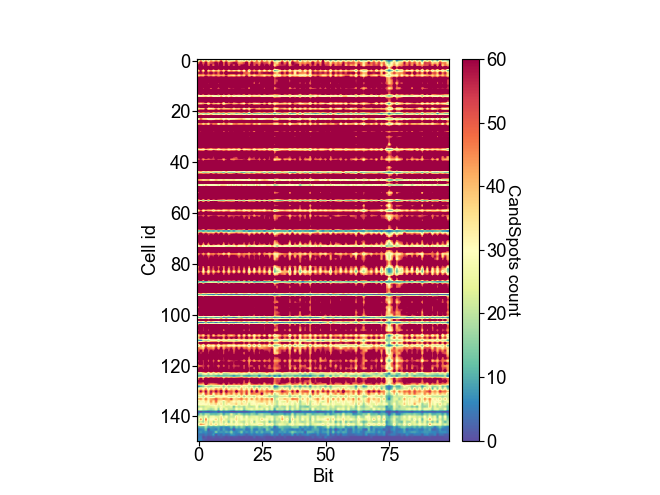

-- save iamage to file: H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Figures\Conv_zscan_05_SpotCountPerCell.png


In [185]:
from ImageAnalysis3.figure_tools import plot_segmentation
count_savefig = os.path.join(cand_spot_folder, 'Figures', _segment_fov_name.replace('.dax', '_SpotCountPerCell.png'))
if not os.path.exists(os.path.dirname(count_savefig)):
    os.makedirs(os.path.dirname(count_savefig))

count_ax = plot_cell_spot_counts(cell_spots_counts, save=True, save_filename=count_savefig)

## 2.3 save partitioned spots

### Old

In [188]:
# save spots
for _cell_id, _spots_list in cell_2_spots.items():
    _cand_filename = os.path.join(cand_spot_folder, _segment_fov_name.replace('.dax', f'_Cell-{_cell_id}_CandSpots.pkl') )
    print(_cand_filename)
    pickle.dump(_spots_list, open(_cand_filename, 'wb'))

H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-1_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-2_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-3_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-4_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-5_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-6_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-7_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-8_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-9_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-10_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_

H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-125_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-126_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-127_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-128_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-129_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-130_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-131_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-132_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-133_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_Cell-134_CandSpots.pkl
H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Ca

## New

In [191]:
from ImageAnalysis3.classes import decode

In [210]:
import pandas as pd

In [224]:
columns = ['fov_id', 'cell_id',]
# add spot info
spot_infos = ['height', 'z', 'x', 'y', 'background', 'sigma_z', 'sigma_x', 'sigma_y', 'sin_t', 'sin_p', 'eps']
columns.extend(spot_infos)
# add bits
columns.extend(['bits'])
# add pixel
pixel_infos = ['pixel_z', 'pixel_x', 'pixel_y']
columns.extend(pixel_infos)
# create dataframe



In [231]:
%%time
# add info to spots_df
_spot_info_list = []
for _cell_id, _spot_dict in cell_2_spots.items():
    for _bit, _spots in _spot_dict.items():
        for _spot, _bit in zip(_spots, _spots.bits):
            _spot_info = [_segment_fov_id, _cell_id]
            _spot_info.extend(list(_spot))
            _spot_info.append(_bit)
            _spot_info.extend(list(pixel_sizes))
            # append
            _spot_info_list.append(_spot_info)

Wall time: 15 s


In [232]:
spots_df = pd.DataFrame(_spot_info_list, columns=columns)

In [234]:
cand_spot_filename = os.path.join(cand_spot_folder, _segment_fov_name.replace('.dax', f'_CandSpots.csv') )
print(cand_spot_filename)
spots_df.to_csv(cand_spot_filename)

H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_CandSpots.csv


In [236]:
print(cand_spot_folder)

H:\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots


In [204]:
%%time
for _cell_id, _spot_dict in cell_2_spots.items():
    _cand_spots = ia.classes.decode.spots_dict_to_cand_spots(_spot_dict, pixel_sizes=pixel_sizes,
                                                            normalize_intensity=False, refine_chromatic=False)
    _cand_filename = os.path.join(cand_spot_folder, _segment_fov_name.replace('.dax', f'_Cell-{_cell_id}_CandSpots') )
    # save spots
    np.save(_cand_filename, _cand_spots)
    # save bits
    np.save(_cand_filename+'_bits', _cand_spots.bits)

Wall time: 283 ms


In [205]:
test_cand_spots = np.load(_cand_filename+'.npy')
test_cand_spot_bits = np.load(_cand_filename+'_bits.npy')

In [206]:
test_cand_spots.shape

(18, 11)

In [207]:
test_cand_spot_bits

array([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  4, 27, 44,
       52])

# 3. Test Decoding

## 3.1 load codebook

In [209]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


## load spot files